# i. Imports and load the data 

In [24]:
import re
from pathlib import Path
import os

from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import nfl_data_py as nfl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

n_cores = os.cpu_count()

In [25]:
train_data_path = Path('../data/processed/field_goal_data.parquet')
fg_attempts = (
    pd.read_parquet(train_data_path)
    .assign(
        iced_kicker=lambda x: x['iced_kicker'].astype(int)
    )
    .merge(
        pd.read_csv('../data/processed/stadium_elevations.csv')
            [['stadium_id','elevation_feet']],
        on='stadium_id',
        how='left'
    )
    .drop_duplicates()
)
fg_attempts.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,qtr,quarter_seconds_remaining,game_seconds_remaining,stadium,stadium_id,is_home,is_indoor,roof,grass_surface,lighting_condition,posteam,defteam,posteam_score,defteam_score,score_differential,kicker_player_name,kicker_player_id,kicker_headshot_url,kicker_height,kicker_weight,kicker_years_exp,kicker_draft_number,kicker_age,kicker_rich_hill,temperature,chance_of_rain,snow_severity,wind_speed,wind_gust,yardline_100,tie_or_take_lead,to_stay_within_one_score,pressure_rating,iced_kicker,field_goal_result,elevation_feet
0,2010,1,2010_01_GB_PHI,660.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T20:37:49Z,1.0,268.0,2968.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,0.0,0.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,27.0,1,0,0.0,0,made,33
1,2010,1,2010_01_GB_PHI,3652.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T23:14:33Z,4.0,346.0,346.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,17.0,27.0,-10.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,5.0,0,1,1.0,0,made,33
2,2010,4,2010_04_WAS_PHI,865.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T20:54:58Z,2.0,900.0,2700.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,0.0,14.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,31.0,0,0,0.0,0,made,33
3,2010,4,2010_04_WAS_PHI,1680.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T21:35:05Z,2.0,23.0,1823.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,3.0,17.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,6.0,0,0,0.0,0,made,33
4,2010,5,2010_05_PHI_SF,986.0,2010-10-10,"10/10/10, 20:30:42",2010-10-11T01:09:05Z,2.0,705.0,2505.0,Candlestick Park,SFO00,-1,0,outdoors,1,2,PHI,SF,7.0,7.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.836,0.5,71.0,0.0,0,10.0,10.0,14.0,1,0,0.0,0,made,35


In [26]:
fg_attempts.field_goal_result.value_counts(normalize=False)

made       13325
missed      2152
blocked      310
Name: field_goal_result, dtype: int64

In [27]:
YEARS = range(2010, 2025)
data_root = Path('../data/raw/weekly_rosters')
data_root.mkdir(parents=True, exist_ok=True)

def load_or_cache_weekly_rosters(year):
    cache_file = data_root / f"{year}.parquet"
    if cache_file.exists():
        print(f"Loading weekly rosters for {year} from cache...")
        return pd.read_parquet(cache_file)
    else:
        print(f"Downloading weekly rosters for {year} from NFL API...")
        df = nfl.import_weekly_rosters([year])
        df.to_parquet(cache_file, index=False)
        print(f"Cached weekly rosters for {year} to {cache_file}")
        return df
def load_all_weekly_rosters(years):
    dataframes = []
    
    for year in years:
        df = load_or_cache_weekly_rosters(year)
        dataframes.append(df)
    
    print(f"Combining weekly rosters for {len(dataframes)} seasons...")
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Total rows: {len(combined_df):,}")
    
    return combined_df
weekly_rosters = load_all_weekly_rosters(YEARS).query('position=="K"')
weekly_rosters.head()

Loading weekly rosters for 2010 from cache...
Loading weekly rosters for 2011 from cache...
Loading weekly rosters for 2012 from cache...
Loading weekly rosters for 2013 from cache...
Loading weekly rosters for 2014 from cache...
Loading weekly rosters for 2015 from cache...
Loading weekly rosters for 2016 from cache...
Loading weekly rosters for 2017 from cache...
Loading weekly rosters for 2018 from cache...
Loading weekly rosters for 2019 from cache...
Loading weekly rosters for 2020 from cache...
Loading weekly rosters for 2021 from cache...
Loading weekly rosters for 2022 from cache...
Loading weekly rosters for 2023 from cache...
Loading weekly rosters for 2024 from cache...
Combining weekly rosters for 15 seasons...
Total rows: 610,092


,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,height,weight,college,player_id,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,pfr_id,fantasy_data_id,sleeper_id,years_exp,headshot_url,ngs_position,week,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number,age
21,2010,PHI,K,None,2,ACT,David Akers,David,Akers,1974-12-09,70.0,200.0,None,00-0000108,None,None,None,None,None,None,None,None,13.0,https://static.www.nfl.com/image/private/f_aut...,None,17,REG,A01,David,AKE551610,None,3200414b-4555-1610-e0e6-a72c82e419e7,1997.0,1997.0,None,None,36.066
22,2010,PHI,K,None,2,ACT,David Akers,David,Akers,1974-12-09,70.0,200.0,None,00-0000108,None,None,None,None,None,None,None,None,13.0,https://static.www.nfl.com/image/private/f_aut...,None,9,REG,A01,David,AKE551610,None,3200414b-4555-1610-e0e6-a72c82e419e7,1997.0,1997.0,None,None,35.912
23,2010,PHI,K,None,2,ACT,David Akers,David,Akers,1974-12-09,70.0,200.0,None,00-0000108,None,None,None,None,None,None,None,None,13.0,https://static.www.nfl.com/image/private/f_aut...,None,16,REG,A01,David,AKE551610,None,3200414b-4555-1610-e0e6-a72c82e419e7,1997.0,1997.0,None,None,36.052
24,2010,PHI,K,None,2,ACT,David Akers,David,Akers,1974-12-09,70.0,200.0,None,00-0000108,None,None,None,None,None,None,None,None,13.0,https://static.www.nfl.com/image/private/f_aut...,None,13,REG,A01,David,AKE551610,None,3200414b-4555-1610-e0e6-a72c82e419e7,1997.0,1997.0,None,None,35.981
25,2010,PHI,K,None,2,ACT,David Akers,David,Akers,1974-12-09,70.0,200.0,None,00-0000108,None,None,None,None,None,None,None,None,13.0,https://static.www.nfl.com/image/private/f_aut...,None,11,REG,A01,David,AKE551610,None,3200414b-4555-1610-e0e6-a72c82e419e7,1997.0,1997.0,None,None,35.951


# ii. Load the trained model

In [28]:
model_path = Path('../models/fg_model_trace.nc')
if model_path.exists():
    trace = az.from_netcdf(model_path)
    print("Trace loaded successfully.")
else:
    print(f"Model file {model_path} does not exist. Please check the path or run the model first.")

Trace loaded successfully.


# iii. Define the dataset of "replacement" kickers

### **Definition: Replacement Kicker Season**

A kicker season is classified as a **replacement kicker season** if it satisfies either of the following conditions:

---

#### **Case 1: Mid-Season Pickup, Not Retained**

Let *k* be a kicker, *t* a team, and *s* a season. The season *(k, t, s)* is a replacement season if:

1. *k* is the first kicker to attempt a field goal for *t* in season *s*, and  
2. *k* was **not on the active roster in Week 1** of season *s*, and  
3. *k* is **not the starting kicker** for team *t* in season *s + 1*, and  
4. *k* **did not kick** for team *t* in season *s − 1*.

---

#### **Case 2: Short-Term Rookie Tenure**

Let *k* be a kicker whose rookie season is *s₀*. The season *(k, t, s₀)* is a replacement season if:

1. *k* is a **rookie** in season *s₀* or **second** season *s₀ + 1* and
2. *k* **did not record at least 10 field goal attempts** for team *t* in either season *s₀ + 2* or *s₀ + 3*.


In [29]:
# Replacement if:
    # CASE 1: player picked up mid-season and not retained as the starting kicker the next season
        # First player to attempt a kick for that team that season
        # Joins roster after week 1 (not on active roster in week 1)
        # Not the same teams starting kicker the next season
        # Did not kick for the same team the previous season
    # CASE 2: rookie kicker who is no longer a team starter after 2 season
        # did not register at least 10 kicks with the team in their 3rd or 4th seasons

In [30]:
team_mapper = {
    'BLT': 'BAL',
    'OAK': 'LV',
    'SD': 'LAC',
    'SL': 'LA',
    'HST': 'HOU',
    'ARZ': 'ARI',
    'CLV': 'CLE',
}
active_weekly_kickers = (
    weekly_rosters
    [['season','week','team','player_name','player_id','rookie_year','years_exp']]
    .rename(columns={
        'player_name': 'kicker_player_name',
        'player_id': 'kicker_player_id'
    })
    .sort_values(['season','team','week'])
    .assign(
        team=lambda x: x['team'].replace(team_mapper),
    )
)


# Add the number of kick attempts for each kicker in each week
weekly_kick_attempts = (
    fg_attempts
    [['season','week','posteam','kicker_player_name','kicker_years_exp','kicker_player_id']]
    .rename(columns={
        'posteam': 'team',
    })
    .groupby(['season','week','team','kicker_player_name','kicker_years_exp','kicker_player_id'])
    .aggregate({'kicker_player_id': 'count'})
    .rename(columns={
        'kicker_player_id': 'attempts',
    })
    .query('attempts > 0')
    .reset_index()
    .rename(columns={
        'kicker_years_exp': 'years_exp',
    })
)
active_weekly_kickers = (
    active_weekly_kickers
    .merge(
        weekly_kick_attempts.drop(columns=['kicker_player_name', 'years_exp']),
        on=['season','week','team','kicker_player_id'],
        how='left'
    )
    .fillna({'attempts': 0})
)
active_weekly_kickers = (
    pd.concat([
        active_weekly_kickers
            .assign(
                original_df=True
            ),
        weekly_kick_attempts
            .assign(
                rookie_year=lambda x: x['season'] - x['years_exp'],
                original_df=False
            )
            [list(active_weekly_kickers.columns) + ['original_df']]
    ])
    .sort_values(['season','team', 'week', 'kicker_player_id','original_df'], ascending=[True, True, True, True, False])
    .drop_duplicates(['season','team','kicker_player_id','week'])
    .drop(columns=['original_df'])
    .reset_index(drop=True)
    .assign(
        rookie_season=lambda x: x['rookie_year'] == x['season'],
        second_season=lambda x: x['rookie_year'] + 1 == x['season'],
        third_season=lambda x: x['rookie_year'] + 2 == x['season'], 
        fourth_season=lambda x: x['rookie_year'] + 3 == x['season'],
    )
)


# Find the starting kicker for each team in week 1 of each season
week_one_starting_kickers = (
    fg_attempts
    .sort_values(['season','week','game_id','posteam','game_seconds_remaining'], ascending=[True, True, True, True, False])
    .drop_duplicates(['season','posteam'])
    [['season','posteam','kicker_player_id']]
    .rename(columns={
        'posteam': 'team',
        'kicker_player_id': 'season_starting_kicker_player_id'
    })
)
active_weekly_kickers = (
    active_weekly_kickers
    .merge(
        week_one_starting_kickers,
        on=['season','team'],
        how='left'
    )
    .assign(
        season_starting_kicker=lambda x: x['kicker_player_id'] == x['season_starting_kicker_player_id']
    )
    .drop(columns=['season_starting_kicker_player_id'])
)


# Find out if the kicker was on the active roster in week 1 of that season
week_one_kickers =(
    active_weekly_kickers
    .query('week==1')
    [['season','team','kicker_player_id']]
    .rename(columns={
        'kicker_player_id': 'kicker_player_id_week_one'
    })
)
active_weekly_kickers = (
    active_weekly_kickers
    .merge(
        week_one_kickers,
        on=['season','team'],
        how='left'
    )
    .assign(
        on_active_roster_week_one=lambda x: x['kicker_player_id'] == x['kicker_player_id_week_one'],
    )
    .sort_values(['season','team','kicker_player_name','week', 'on_active_roster_week_one'], ascending=[True, True, True, True, False])
    .drop_duplicates(['season','team','kicker_player_id','week'])
    .drop(columns=['kicker_player_id_week_one'])
)


# Add column to indicate if the kicker was the starting kicker in week 1 of the next season
week_one_starting_kickers_next_season = (
    week_one_starting_kickers
    .rename(columns={
        'season_starting_kicker_player_id': 'season_starting_kicker_player_id_next_season'
    })
    .assign(
        season=lambda x: x['season'] - 1.
    )
)
active_weekly_kickers = (
    active_weekly_kickers
    .merge(
        week_one_starting_kickers_next_season,
        on=['season','team'],
        how='left'
    )
    .assign(
        season_starting_kicker_next_season=lambda x: x['kicker_player_id'] == x['season_starting_kicker_player_id_next_season']
    )
    .drop(columns=['season_starting_kicker_player_id_next_season'])
)


# Find out if they kicked for the team they kicked for the team the previous season
active_kickers_previous_season = (
    active_weekly_kickers
    # .query('attempts > 0')
    [['season','team','kicker_player_id']]
    .rename(columns={
        'team': 'team_previous_season'
    })
    .assign(
        season=lambda x: x['season'] + 1
    )
)
active_weekly_kickers = (
    active_weekly_kickers
    .merge(
        active_kickers_previous_season,
        on=['season','kicker_player_id'],
        how='left'
    )
    .assign(
        kicked_for_team_previous_season=lambda x: x['team'] == x['team_previous_season']
    )
    .sort_values(['season','team','kicker_player_name','week','kicked_for_team_previous_season'], ascending=[True, True, True, True, False])
    .drop_duplicates(['season','team','kicker_player_id','week'])
    .drop(columns=['team_previous_season'])
)


# Number of fg attemps by a third and fourth year kicker on the same team
third_season_attempts = (
    active_weekly_kickers
    .query('third_season')
    .groupby(['season','team','kicker_player_id'])
    .aggregate({'attempts': 'sum'})
    .reset_index()
    .rename(columns={
        'attempts': 'attempts_third_season'
    })
)
fourth_season_attempts = (
    active_weekly_kickers
    .query('fourth_season')
    .groupby(['season','team','kicker_player_id'])
    .aggregate({'attempts': 'sum'})
    .reset_index()
    .rename(columns={
        'attempts': 'attempts_fourth_season'
    })
)

active_weekly_kickers = (
    active_weekly_kickers

    # Merge to rookie season
    .merge(
        third_season_attempts.assign(season=lambda x: x['season'] - 2),
        on=['season','team','kicker_player_id'],
        how='left'
    )
    .merge(
        fourth_season_attempts.assign(season=lambda x: x['season'] - 3),
        on=['season','team','kicker_player_id'],
        how='left'
    )

    # Merge to second season
    .merge(
        third_season_attempts.assign(season=lambda x: x['season'] - 1),
        on=['season','team','kicker_player_id'],
        how='left',
        suffixes=('', '_second_season')
    )
    .merge(
        fourth_season_attempts.assign(season=lambda x: x['season'] - 2),
        on=['season','team','kicker_player_id'],
        how='left',
        suffixes=('', '_second_season')
    )
    

    .assign(
        attempts_third_season=lambda x: x['attempts_third_season'].fillna(x['attempts_third_season_second_season']).fillna(0),  
        attempts_fourth_season=lambda x: x['attempts_fourth_season'].fillna(x['attempts_fourth_season_second_season']).fillna(0) 
    )
    .drop(
        columns=[
            'attempts_third_season_second_season',
            'attempts_fourth_season_second_season'
        ]
    )
)

active_weekly_kickers.head()

,season,week,team,kicker_player_name,kicker_player_id,rookie_year,years_exp,attempts,rookie_season,second_season,third_season,fourth_season,season_starting_kicker,on_active_roster_week_one,season_starting_kicker_next_season,kicked_for_team_previous_season,attempts_third_season,attempts_fourth_season
0,2010,1,ARI,Jay Feely,00-0019770,2001.0,9.0,1.0,False,False,False,False,True,True,True,False,0.0,0.0
1,2010,2,ARI,Jay Feely,00-0019770,2001.0,9.0,1.0,False,False,False,False,True,True,True,False,0.0,0.0
2,2010,3,ARI,Jay Feely,00-0019770,2001.0,9.0,1.0,False,False,False,False,True,True,True,False,0.0,0.0
3,2010,4,ARI,Jay Feely,00-0019770,2001.0,9.0,1.0,False,False,False,False,True,True,True,False,0.0,0.0
4,2010,5,ARI,Jay Feely,00-0019770,2001.0,9.0,3.0,False,False,False,False,True,True,True,False,0.0,0.0


In [31]:
replacement_kicker_seasons = (
    pd.concat([
        # CASE 1: player picked up mid-season and not retained as the starting kicker the next season
        active_weekly_kickers.query(
            '~season_starting_kicker and ' # Not the starting kicker for the team that season
            '~on_active_roster_week_one and '  # Not on active roster in week 1
            '~season_starting_kicker_next_season and '  # Not the same teams starting kicker the next season
            '~kicked_for_team_previous_season'  # Did not kick for the same team the previous season
        ),
        # CASE 2: rookie kicker who is no longer an active team starter after 2 seasons
        active_weekly_kickers.query(
            '(rookie_season or second_season) and '  # Rookie season or second season
            ' attempts_third_season < 10 and '  # Did not register at least 10 kicks with the team in their 3rd season
            ' attempts_fourth_season < 10'  # Did not register at least 10 kicks with the team in their 4th season
        )
    ])
)[['season','team','kicker_player_id','kicker_player_name']].drop_duplicates().reset_index(drop=True)

n_replacement_kicker_seasons = len(replacement_kicker_seasons)
n_kicker_seasons = len(fg_attempts.drop_duplicates(['season','kicker_player_id']))
print(f"Number of replacement kicker seasons: {n_replacement_kicker_seasons/n_kicker_seasons:.2f} ({n_replacement_kicker_seasons}/{n_kicker_seasons})")

n_replacement_fg_attempts = (
    fg_attempts.merge(
        replacement_kicker_seasons.rename(columns={'team':'posteam'}),
        on=['season','posteam','kicker_player_id'],
        how='left',
        suffixes=('', '_replacement')
    )
    .assign(
        replacement_kicker=lambda x: x['kicker_player_name_replacement'].notna()
    )
    .drop(columns=['kicker_player_name_replacement'])
).replacement_kicker.value_counts()[True]
n_fg_attempts = len(fg_attempts)
print(f"Number of field goal attempts by replacement kickers: {n_replacement_fg_attempts/n_fg_attempts:.2f} ({n_replacement_fg_attempts}/{n_fg_attempts})")

Number of replacement kicker seasons: 0.53 (317/603)
Number of field goal attempts by replacement kickers: 0.14 (2153/15787)


# iv. Calculate FGPAR (FG Points Above Replacement)

In [32]:
dataset = (
    fg_attempts
    .query('field_goal_result.isin(["made", "missed"])')
    .copy()
    .query('season >= 2015') # Train on 10 seasons
)

dataset["kicker_season"] = dataset["kicker_player_id"].astype(str) + "_" + dataset["season"].astype(str)
kicker_season_ids, kicker_season_idx = np.unique(dataset["kicker_season"], return_inverse=True)
n_kicker_seasons = len(kicker_season_ids)

# Kicker intercepts
from collections import defaultdict
kicker_season_map = defaultdict(list)
for i, (kicker_id, season) in enumerate(zip(dataset["kicker_player_id"], dataset["season"])):
    kicker_season_map[kicker_id].append((season, i))
dataset["kicker_season"] = [
    f"{kicker_id}_{season}" for kicker_id, season in zip(dataset["kicker_player_id"], dataset["season"])
]  

unique_kicker_seasons = dataset["kicker_season"].unique()
n_kicker_seasons = len(unique_kicker_seasons)

# Create a matrix to map from kicker-season to their position in the GRW
kicker_season_grw_idx = np.zeros(len(dataset), dtype=int)
for kicker_season_idx, kicker_season in enumerate(unique_kicker_seasons):
    kicker_season_grw_idx[dataset["kicker_season"] == kicker_season] = kicker_season_idx

dataset["kicker_season_grw_idx"] = kicker_season_grw_idx

dataset = (
    dataset
    .merge(
        replacement_kicker_seasons.rename(columns={'team':'posteam'}),
        on=['season','posteam','kicker_player_id'],
        how='left',
        suffixes=('', '_replacement')
    )
    .assign(
        replacement_kicker=lambda x: x['kicker_player_name_replacement'].notna()
    )
    .drop(columns=['kicker_player_name_replacement'])
)

In [33]:
# Get posterior samples of kicker parameters
kicker_intercepts = trace.posterior["kicker_season_intercept"].values  # shape: (chains, draws, n_kicker_seasons)
kicker_slopes = trace.posterior["kicker_season_ytg_slope"].values

# Reshape to combine chains
n_chains, n_draws, n_kicker_seasons = kicker_intercepts.shape
kicker_intercepts = kicker_intercepts.reshape(-1, n_kicker_seasons)  # shape: (n_samples, n_kicker_seasons)
kicker_slopes = kicker_slopes.reshape(-1, n_kicker_seasons)

# Create mapping from kicker-season to index
kicker_season_to_idx = {ks: i for i, ks in enumerate(dataset["kicker_season"].unique())}

# Get indices of replacement kickers
replacement_mask = dataset["replacement_kicker"].values
replacement_indices = np.array([kicker_season_to_idx[ks] 
                               for ks in dataset.loc[replacement_mask, "kicker_season"]])

# Sample replacement parameters (n_samples × n_replacement_kickers)
n_samples = 1000
sample_indices = np.random.choice(len(kicker_intercepts), size=n_samples, replace=True)
replacement_intercepts = kicker_intercepts[sample_indices][:, replacement_indices]
replacement_slopes = kicker_slopes[sample_indices][:, replacement_indices]

# Create average replacement parameters
avg_replacement_intercept = replacement_intercepts.mean(axis=1)  # shape: (n_samples,)
avg_replacement_slope = replacement_slopes.mean(axis=1)

# Scale and transform features
scaler = StandardScaler()
ytg_poly2 = scaler.fit_transform(
    PolynomialFeatures(
        degree=2, 
        include_bias=False
    ).fit_transform(dataset[['yardline_100']])
)[:, 1]
temperature = scaler.fit_transform(dataset[['temperature']]).flatten()
precipitation_chance = scaler.fit_transform(dataset[['chance_of_rain']]).flatten()
snow_severity = scaler.fit_transform(dataset[['snow_severity']]).flatten()
wind_gust = scaler.fit_transform(dataset[['wind_gust']]).flatten()
elevation = scaler.fit_transform(dataset[['elevation_feet']]).flatten()
outdoor_indicator = dataset['is_indoor'].eq(0).astype(int).values  # 1 if outdoor, else 0
is_home = scaler.fit_transform(dataset['is_home'].astype(int).values.reshape(-1, 1)).flatten()
lighting_condition = scaler.fit_transform(dataset['lighting_condition'].astype(int).values.reshape(-1, 1)).flatten()
pressure_rating = scaler.fit_transform(dataset['pressure_rating'].values.reshape(-1, 1)).flatten()
iced_kicker = scaler.fit_transform(dataset['iced_kicker'].astype(int).values.reshape(-1, 1)).flatten()
season_scaled = scaler.fit_transform(dataset[['season']]).flatten()

# Response
y = (dataset['field_goal_result'] == 'made').astype(int).values

# Get posterior samples for all parameters
alpha_samples = trace.posterior["alpha"].values.reshape(-1)  # Flatten chains and draws
beta_home_samples = trace.posterior["beta_home"].values.reshape(-1)
beta_timeofday_samples = trace.posterior["beta_timeofday"].values.reshape(-1)
beta_pressure_samples = trace.posterior["beta_pressure"].values.reshape(-1)
beta_iced_samples = trace.posterior["beta_iced"].values.reshape(-1)
beta_pressure_iced_samples = trace.posterior["beta_pressure_iced"].values.reshape(-1)
beta_season_samples = trace.posterior["beta_season"].values.reshape(-1)
beta_wind_samples = trace.posterior["beta_wind"].values.reshape(-1)
beta_wind_ytg_samples = trace.posterior["beta_wind_ytg"].values.reshape(-1)
beta_temp_samples = trace.posterior["beta_temp"].values.reshape(-1)
beta_temp_ytg_samples = trace.posterior["beta_temp_ytg"].values.reshape(-1)
beta_precip_samples = trace.posterior["beta_precip"].values.reshape(-1)
beta_precip_ytg_samples = trace.posterior["beta_precip_ytg"].values.reshape(-1)
beta_snow_samples = trace.posterior["beta_snow"].values.reshape(-1)
beta_snow_ytg_samples = trace.posterior["beta_snow_ytg"].values.reshape(-1)
beta_elev_samples = trace.posterior["beta_elev"].values.reshape(-1)
beta_elev_ytg_samples = trace.posterior["beta_elev_ytg"].values.reshape(-1)

# Calculate replacement probabilities for all attempts
replacement_probs = np.zeros((n_samples, len(dataset)))
for i in range(n_samples):
    # Randomly sample indices for each parameter
    sample_idx = np.random.randint(len(alpha_samples))
    
    # Use the sampled values for this iteration
    alpha = alpha_samples[sample_idx]
    beta_home = beta_home_samples[sample_idx]
    beta_timeofday = beta_timeofday_samples[sample_idx]
    beta_pressure = beta_pressure_samples[sample_idx]
    beta_iced = beta_iced_samples[sample_idx]
    beta_pressure_iced = beta_pressure_iced_samples[sample_idx]
    beta_season = beta_season_samples[sample_idx]
    beta_wind = beta_wind_samples[sample_idx]
    beta_wind_ytg = beta_wind_ytg_samples[sample_idx]
    beta_temp = beta_temp_samples[sample_idx]
    beta_temp_ytg = beta_temp_ytg_samples[sample_idx]
    beta_precip = beta_precip_samples[sample_idx]
    beta_precip_ytg = beta_precip_ytg_samples[sample_idx]
    beta_snow = beta_snow_samples[sample_idx]
    beta_snow_ytg = beta_snow_ytg_samples[sample_idx]
    beta_elev = beta_elev_samples[sample_idx]
    beta_elev_ytg = beta_elev_ytg_samples[sample_idx]
    
    # Calculate logit_p using the sampled parameters
    logit_p = (
        alpha
        + avg_replacement_intercept[i] 
        + avg_replacement_slope[i] * ytg_poly2
        + beta_home * is_home
        + beta_timeofday * lighting_condition
        + beta_pressure * pressure_rating
        + beta_iced * iced_kicker
        + beta_pressure_iced * pressure_rating * iced_kicker
        + beta_season * season_scaled
        + beta_wind * wind_gust * outdoor_indicator
        + beta_wind_ytg * wind_gust * ytg_poly2 * outdoor_indicator
        + beta_temp * temperature * outdoor_indicator
        + beta_temp_ytg * temperature * ytg_poly2 * outdoor_indicator
        + beta_precip * precipitation_chance * outdoor_indicator
        + beta_precip_ytg * precipitation_chance * ytg_poly2 * outdoor_indicator
        + beta_snow * snow_severity * outdoor_indicator
        + beta_snow_ytg * snow_severity * ytg_poly2 * outdoor_indicator
        + beta_elev * elevation * outdoor_indicator
        + beta_elev_ytg * elevation * ytg_poly2 * outdoor_indicator
    )
    replacement_probs[i] = 1 / (1 + np.exp(-logit_p))

# Calculate FGPAR for each kicker-season
results = []
for (kicker_season, kicker_id, season), group in tqdm(
    dataset.groupby(["kicker_season", "kicker_player_id", "season"]),
    desc="Calculating FGPAR for each kicker-season",
    total=dataset["kicker_season"].nunique()
):
    mask = (dataset["kicker_season"] == kicker_season).values
    actual_results = y[mask]
    actual_points = actual_results * 3
    
    for sample in range(n_samples):
        replacement_points = replacement_probs[sample, mask] * 3
        fgpar = (actual_points - replacement_points).sum()
        
        results.append({
            "kicker_player_id": kicker_id,
            "season": season,
            "kicker_season": kicker_season,
            "sample": sample,
            "FGPAR": fgpar,
            "n_attempts": len(actual_results),
            "fg_made": actual_results.sum(),
            "fg_attempts": len(actual_results)
        })

# Convert to DataFrame and calculate summary stats
results_df = pd.DataFrame(results)
summary_df = results_df.groupby(["kicker_player_id", "season", "kicker_season"]).agg({
    "FGPAR": ["mean", "std", lambda x: np.quantile(x, 0.05), lambda x: np.quantile(x, 0.95)],
    "n_attempts": "first",
    "fg_made": "first",
    "fg_attempts": "first"
}).reset_index()

# Flatten multi-index columns
summary_df.columns = ['_'.join(col).strip('_') for col in summary_df.columns.values]
summary_df = summary_df.rename(columns={
    "FGPAR_mean": "FGPAR",
    "FGPAR_<lambda_0>": "FGPAR_5th",
    "FGPAR_<lambda_1>": "FGPAR_95th",
    "n_attempts_first": "n_attempts"
})

summary_df.rename(columns={
    "fg_made_first": "fg_made",
    "fg_attempts_first": "fg_attempts",
}, inplace=True)

# Add success rate
summary_df["fg_pct"] = summary_df["fg_made"] / summary_df["fg_attempts"]

summary_df = (
    dataset[['kicker_player_id', 'season', 'kicker_player_name']]
    .drop_duplicates()
    .merge(summary_df, on=['kicker_player_id', 'season'], how='left')
)

summary_df.head()

Calculating FGPAR for each kicker-season: 100%|██████████| 418/418 [00:11<00:00, 36.76it/s]


,kicker_player_id,season,kicker_player_name,kicker_season,FGPAR,FGPAR_std,FGPAR_5th,FGPAR_95th,n_attempts,fg_made,fg_attempts,fg_pct
0,00-0004091,2015,Phil Dawson,00-0004091_2015,9.912854,9.452618,-0.483075,28.992888,25,24,25,0.960000
1,00-0004091,2016,Phil Dawson,00-0004091_2016,4.888879,9.481219,-6.183160,23.327087,21,18,21,0.857143
2,00-0004091,2017,Phil Dawson,00-0004091_2017,1.335432,14.350407,-14.265552,30.616827,38,32,38,0.842105
3,00-0004091,2018,Phil Dawson,00-0004091_2018,-5.033522,3.021192,-8.295717,1.278400,8,5,8,0.625000
4,00-0016919,2015,Adam Vinatieri,00-0016919_2015,11.195133,11.508740,-2.295645,33.893180,27,25,27,0.925926


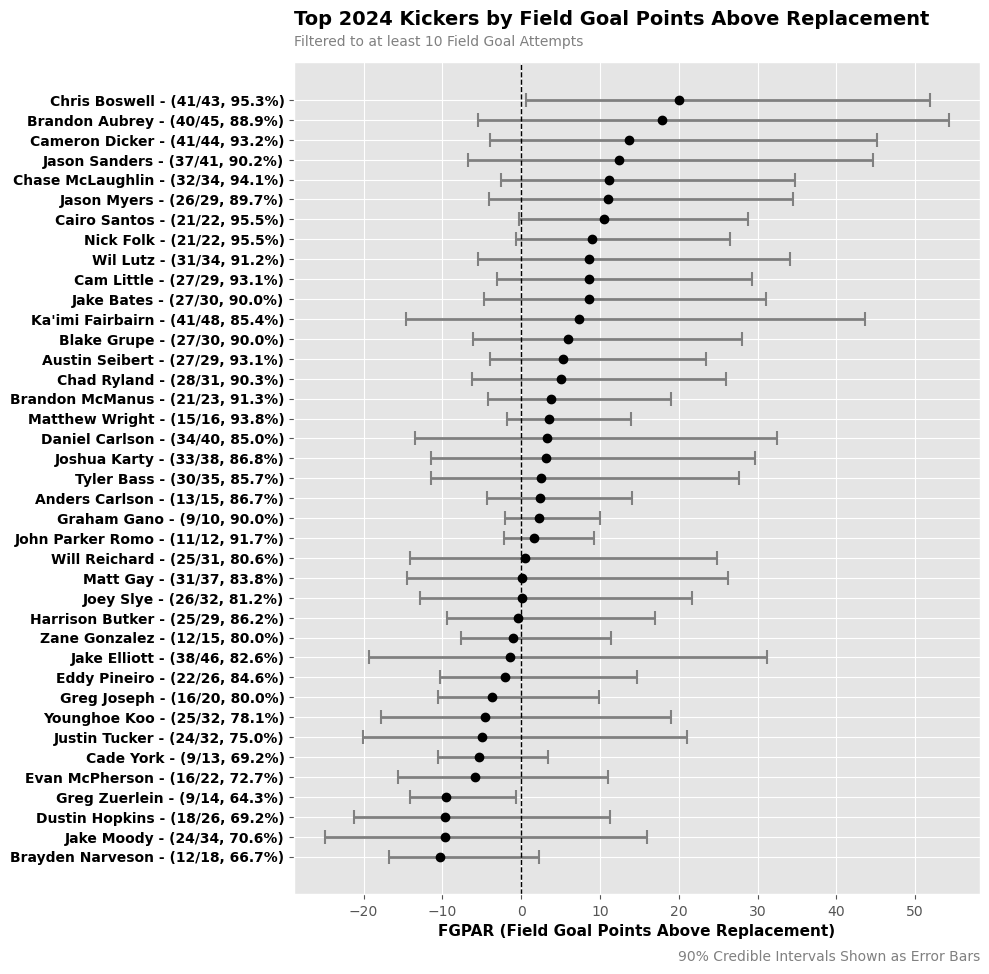

Plot saved to ../images/top_kickers_fgpar_2024.png


In [34]:
import matplotlib.pyplot as plt

# ggplot style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'

# Sort by FGPAR descending
top_kickers = (
    summary_df
    .query('season == 2024 and n_attempts >= 10')
    .sort_values('FGPAR', ascending=False)  # Ascending so best kicker is at top of plot
)

# Build labels with bold names and percentages
labels = [
    f"{row.kicker_player_name} - ({row.fg_made}/{row.fg_attempts}, {row.fg_pct:.1%})"
    for _, row in top_kickers.iterrows()
]

fig, ax = plt.subplots(figsize=(10, 0.25 * len(top_kickers)))

y_pos = range(len(top_kickers))

# Error bars for 90% credible intervals
ax.errorbar(
    top_kickers["FGPAR"],
    y_pos,
    xerr=[
        top_kickers["FGPAR"] - top_kickers["FGPAR_5th"],
        top_kickers["FGPAR_95th"] - top_kickers["FGPAR"]
    ],
    fmt='o',
    color='black',
    ecolor='gray',
    capsize=5,
    elinewidth=2,
    capthick=1.5
)

# Vertical lines for 0 FGPAR
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Y-axis settings
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=10, fontweight='bold', color='black')
ax.invert_yaxis()

ax.set_xlabel(
    "FGPAR (Field Goal Points Above Replacement)", 
    fontsize=11,
    fontweight='bold',
    color='black'
)
ax.set_title(
    "Top 2024 Kickers by Field Goal Points Above Replacement", 
    fontsize=14,
    x=0,  # Center the title
    y=1.035,  # Adjust vertical position
    ha='left',  # Align left
    fontweight='bold',
    color='black'
)
ax.text(
    0, 1.02,  # Position: centered below the title
    "Filtered to at least 10 Field Goal Attempts",
    fontsize=10,
    color="gray",
    ha="left",
    transform=ax.transAxes
)
# bottom right info about 90% credible intervals
ax.text(
    1, -.08,  # Position: bottom right
    "90% Credible Intervals Shown as Error Bars",
    fontsize=10,
    color="gray",
    ha="right",
    transform=ax.transAxes
)
plt.grid(True)
plt.tight_layout()
plt.show()

# save plot to ../images/top_kickers_fgpar_2024.png
output_path = Path('../images/top_kickers_fgpar_2024.png')
output_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, bbox_inches='tight', dpi=1000)
print(f"Plot saved to {output_path}")

# v. Investigate impacts of variables on fg probability